In [6]:
import pyoti.sparse as oti
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

In [7]:
x = oti.array([1,2,3])
x

matso< shape: (3, 1), 
 - Column 0
(0,0) 1
(1,0) 2
(2,0) 3
>

In [8]:
x.T

matso< shape: (1, 3), 
 - Column 0
(0,0) 1
 - Column 1
(0,1) 2
 - Column 2
(0,2) 3
>

In [15]:
def fun2(X,r,m,b):
    #INTERSECTION BETWEEN CURVES.
    f = oti.zeros((2,1))
    x = X[0,0].copy()
    y = X[1,0].copy()
    f[0,0] = x**2 + y**2 - r**2 
    f[1,0] = y - ( m * x + b )
    return f

def fun2_curves(x,r,m,b):
    #CURVES.
    y = oti.zeros((x.shape[0],3))
    y[:,0] =  oti.sqrt(r**2 - x**2)
    y[:,1] = -oti.sqrt(r**2 - x**2)
    y[:,2] = m * x + b
    return y

In [16]:
# utils
def newton_otisis(func, jaco, x, tol, maxiter=50, args=()):
    error = 1e30
    n = 0
    nx = x.shape[0]
    dx = oti.zeros( (nx,1), order=x.order)
    argv = (func,)+args
    while error > tol:
        if n==maxiter:
            print("Did not converge. ", maxiter, "iters.")
            break
        mJ = -jaco(x,*argv)
#         print(mJ.shape)
        f_eval = func(x,*args)
#         print(f_eval.shape)
        dx = oti.dot(oti.inv(mJ),f_eval)
        error = oti.norm(dx).get_deriv(0)        
        x += dx
        n += 1
#     print("niter: ",n)
#     print("rel_err:",(oti.norm(dx)/oti.norm(x)).get_deriv(0))
    return x

def j_DF (x, *arg2):
    h = 1e-8
    nx = x.shape[0]
    J = oti.zeros((nx,nx), order=x.order)
    for i in range(nx):
        xh = x.copy()
        xh[i,0]+= h
        dfdxi = (func(xh,*args) - func(x,*args))/h
        for j in range(nx):
            J[j,i] = dfdxi[j,0]
    return J

def j_oti (x, *argv):
    nx = x.shape[0]
    func = argv[0]
    args = argv[1:]
    active_bases = func(x,*args).get_active_bases()
    if len(active_bases)==0:
        next_base = 1 
    else:
        next_base = max(active_bases) + 1
    # end if 
    e_x = oti.zeros((nx,1), order=x.order)
    for i in range(nx):
        e_x[i] = oti.e(next_base + i)  
    # end for 
    J = oti.zeros((nx,nx), order=x.order)
    fun = func(x+e_x, *args) 
    for n in range(nx):
        J_col = fun.extract_deriv(next_base + n)
        for j in range(nx):
            J_col = J_col.truncate(next_base + j)
        # end for 
        for m in range(nx):
            J[m,n] = J_col[m,0]
        # end for 
    # end for 
    return J

In [17]:
order = 5
x0 = oti.array([1,1])
r  = np.sqrt(5)+oti.e(1, order = order)
m  = 3+oti.e(2, order = order)
b = -5+oti.e(3, order = order)

In [18]:
x = newton_otisis(fun2,j_oti,x0,1e-8, args = (r,m,b))

In [19]:
print(x.real)

[[2.]
 [1.]]


In [28]:
r.real

2.23606797749979

<IPython.core.display.Javascript object>


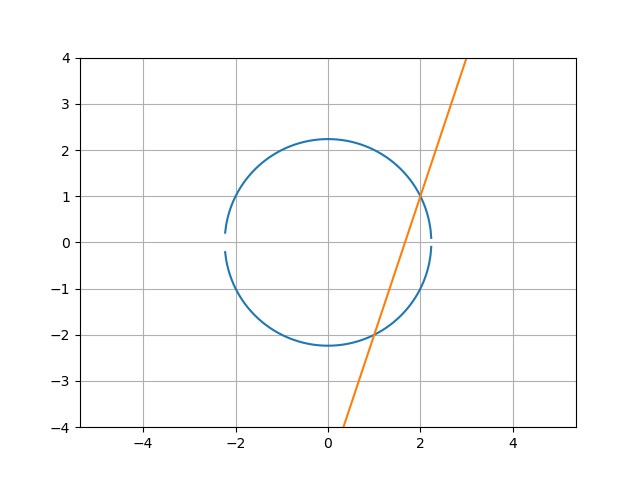

In [35]:
# Plot the system
plt.figure()

d = r.real+2
x_plot_r = np.arange(-d,d,0.01)
x_plot   = oti.array(x_plot_r)

Y = fun2_curves(x_plot,r.real,m.real,b.real)
y_circ_up= Y[:,0]
y_circ_dn= Y[:,1]
y_line   = Y[:,2]

plt.plot(x_plot_r,y_circ_up.real,c='C0')
plt.plot(x_plot_r,y_circ_dn.real,c='C0')

plt.plot(x_plot_r,y_line.real   ,c='C1')

plt.axis('equal')


plt.axis([-4,4,-4,4])
plt.grid()

plt.show()

In [30]:
y_circ_up.real

array([[       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [       nan],
       [0.47021995],
       [0.66122129],
       [0.80518345],
       [0.92435231],
       [1.02739184],
       [1.11876753],
       [1.201

In [17]:
Δr = 0.1
Δm = 0.1
Δb = 0.1
m

3.0000 + 1.0000 * e([2])

In [18]:
rnew = r.rom_eval([1,2,3],[Δr,Δm,Δb])
mnew = m.rom_eval([1,2,3],[Δr,Δm,Δb])
bnew = b.rom_eval([1,2,3],[Δr,Δm,Δb])
xnew = x.rom_eval([1,2,3],[Δr,Δm,Δb])

In [18]:
x.real

array([[2.],
       [1.]])

In [19]:
x0[0,0]

1.0000

In [19]:
fun2(x,r,m,b).real

array([[8.88178420e-16],
       [6.66133815e-16]])

In [20]:
fun2(xnew,rnew,mnew,bnew)

matso< shape: (2, 1), 
 - Column 0
(0,0) -3.90799e-14
(1,0) -5.77316e-15
>